# Counting Objects (hard mode)

In this notebook we'll use [fastai](http://docs.fast.ai) to count the number of identical objects in pictures. I anticipate this will be harder than our previous work because the features of the objects are going to be identical in each image. Also, since we'll be creating our dataset with `matplotlib` our data is going to be coming from a completely different distribution than the one on which ResNet-34 was trained (ImageNet). 

We begin my setting up our notebook and importing the fastai libraries:

In [99]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

import random

import matplotlib.pyplot as plt
import numpy as np

## Creating a dataset

Unlike our previous examples, I was unable to find a suitable dataset for this task. We would like a dataset that contains 1-5 identical elements. Fortunately it should be possible to create such a dataset ourselves. We'll start by generating non-overlapping points and plotting them.

/home/josh/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


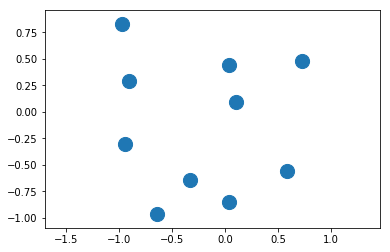

In [100]:
import matplotlib.pyplot as plt

def createNonOverlappingPoints(numElements):
    x = np.zeros((numElements)) + 2  #Place the cirlces offscreen
    y = np.zeros((numElements)) + 2  #Place the circles offscreen
    
    for i in range(0, numElements):
        
        foundNewCircle = False
        
        #Loop until we find a non-overlapping position for our new circle
        while not foundNewCircle:
            randX = random.uniform(-1, 1)
            randY = random.uniform(-1, 1)

            distanceFromOtherCircles = np.sqrt(np.square(x - randX) + np.square(y - randY))

            # Ensure that this circle is far enough away from all others
            if np.all(distanceFromOtherCircles > 0.2):
                break

        x[i] = randX
        y[i] = randY

    return x, y

x, y = createNonOverlappingPoints(10)
plt.scatter(x,y, s=200)
plt.axes().set_aspect('equal', 'datalim')  # before `plt.show()`        
plt.show()  

Now that we can create points, let's build our dataset. We'll generate 1,000 images for each class and save each class in a folder with that classes name. This will take a couple minutes to run.

/home/josh/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


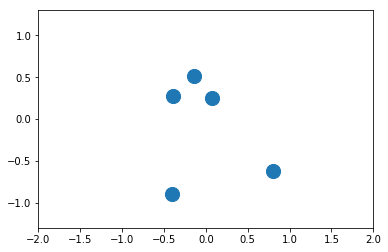

In [136]:
import os
from tqdm import tnrange

#Iterate over our five classes
for i in tnrange(1, 6):
    #Create 1,000 images of this class
    for j in tnrange(1000):
        
        directory = 'data/counting/' + str(i) + '/'
        path = directory + str(j) + '.png'
        os.makedirs(directory, exist_ok=True)

        #Get points
        x, y = createNonOverlappingPoints(i)
        #Create plot
        plt.cla()
        axes = plt.gca()
        axes.set_xlim([-2,2])
        axes.set_ylim([-2, 2])
        plt.scatter(x,y, s=200)
        plt.axes().set_aspect('equal', 'datalim')  # before `plt.show()`       
        #Save to disk
        plt.savefig(path)

With our dataset ready, we can load everything up into an ImageDataBunch and verify it all looks correct.

In [137]:
path = 'data/counting'

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


In [138]:
data.classes

['1', '2', '3', '4', '5']

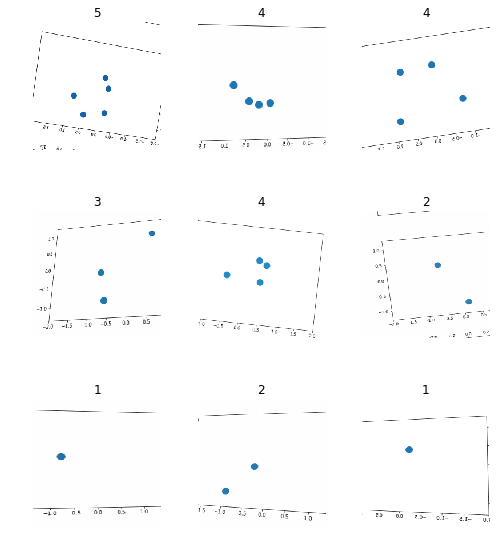

In [139]:
data.show_batch(rows=3, figsize=(7,8))

With this dataset it's a lot easier to see the image transformations (rotations, zooms etc.) that have been made to our dataset. 

## Training a model

In [140]:
learner = create_cnn(data, models.resnet34, metrics=error_rate)

In [141]:
learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate
1,1.350247,0.767537,0.346000
2,0.930266,0.469457,0.165000
3,0.739811,0.415282,0.136000


Without any changes we're sitting at over 85% accuracy! This surprised me as I thought this task would be harder for our neural network. There are certain techniques that would make this task almost trivially solvable (simply count the number of blue pixels) but I didn't think our convolutional neural network would be able to pick up on these.

Let's see how much further we can improve things.

In [144]:
learner.save('stage-1')
learner.unfreeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


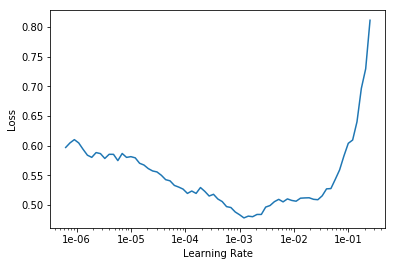

In [132]:
learner.recorder.plot()

It looks like learning rates between `1e-6` and `1e-3` would work for this problem. We'll go somewhere in the middle with `1e-4` and run for a few more epochs.

In [145]:
learner.fit_one_cycle(15, max_lr=slice(1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.657094,0.406908,0.133000
2,0.632255,0.337327,0.100000
3,0.581926,0.273301,0.056000
4,0.504420,0.223634,0.033000
5,0.450133,0.165811,0.022000
6,0.388026,0.150643,0.021000
7,0.350988,0.087298,0.003000
8,0.296224,0.074188,0.007000
9,0.276927,0.058903,0.003000
10,0.257730,0.060895,0.001000


Nice, we've pushed the accuracy up to ~99%! This surprised me to see as I thought this would be a more challenging task for a convolutional neural network. I had preconceptions about these networks that turned out to be incorrect. Originally I believed that convolutional networks translational invariance property meant that they could detect the presence of a feature, but not necessarily where it was located (due to the convolutional filters being dragged across the image). 

Let's take a look at the the top losses for this experiment.

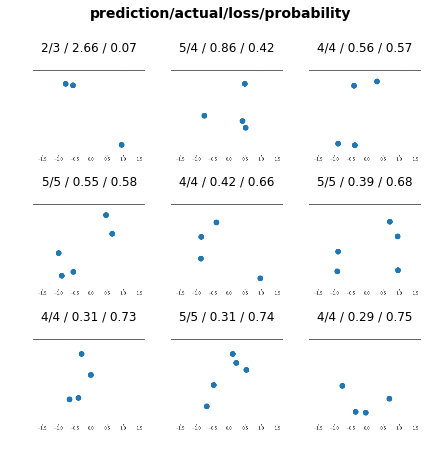

In [146]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)
interp.plot_top_losses(9, figsize=(7,7))

Since we're only getting two incorrect, there doesn't seem to be much to learn from our top losses. We'll take a quick look at the confusion matrix as well.

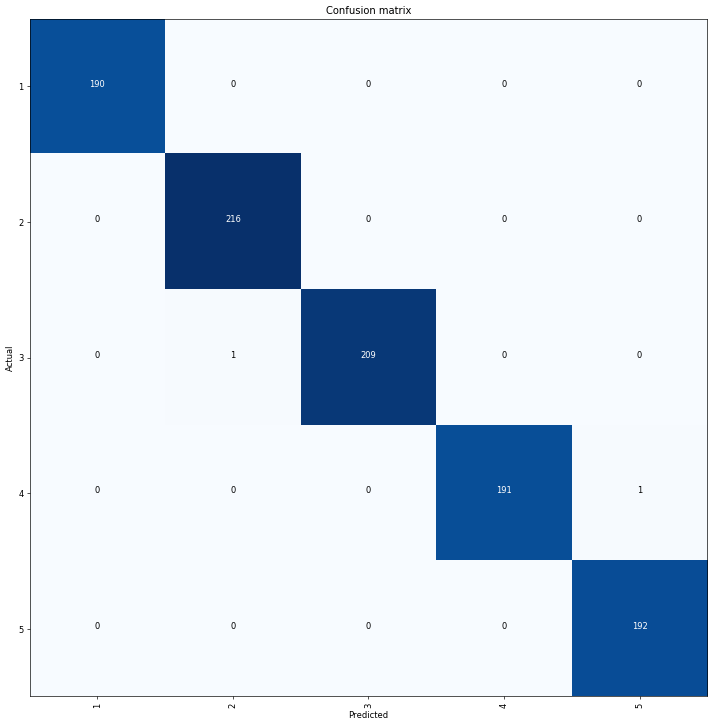

In [148]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


So it looks like I was incorrect. This wasn't a particularly hard task for neural networks. It's seems likely that with even more samples and training time we might be able to reach 100% accuracy.

## One last experiment

There's still one burning question I have: Is the network actually counting? (I personally doubt it) Or is it simply learning to recognize things like whitespace between the circles that can only occur when a certain number of elements are present?

I'm not sure exactly how best to test this but one thought I had was that as we add more circles, it seems like it would be harder to find patterns that uniquely identify a given count. Maybe if we put so many circles on the screen that the unique patterns become very hard to find. For example, instead of trying 1-5 circles, let's try counting images that only have 45-50 circles.

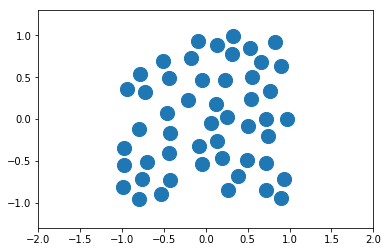

In [150]:
import os
from tqdm import tnrange

#Iterate over our 50 classes
for i in tnrange(45, 51):
    #Create 1,000 images of this class
    for j in tnrange(1000):
        
        directory = 'data/counting/' + str(i) + '/'
        path = directory + str(j) + '.png'
        os.makedirs(directory, exist_ok=True)

        #Get points
        x, y = createNonOverlappingPoints(i)
        #Create plot
        plt.cla()
        axes = plt.gca()
        axes.set_xlim([-2,2])
        axes.set_ylim([-2, 2])
        plt.scatter(x,y, s=200)
        plt.axes().set_aspect('equal', 'datalim')  # before `plt.show()`       
        #Save to disk
        plt.savefig(path)

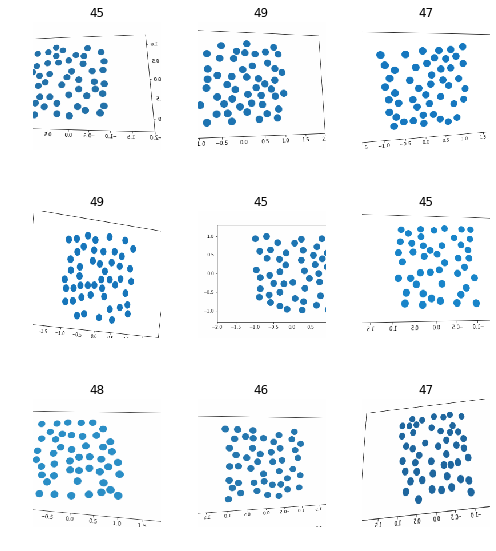

In [151]:
path = 'data/counting'
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,8))

Good luck finding a pattern in that!

Let's see how well it does now.

In [152]:
learner = create_cnn(data, models.resnet34, metrics=error_rate)
learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate
1,2.132017,2.023042,0.795833
2,1.861990,1.643421,0.711667
3,1.749233,1.663559,0.748333


Finally, a 25% accuracy rate! Something a vanilla network can't actually do! Let's see how well we can co-erce it into learning on this dataset, though.

In [153]:
learner.save('stage-1')
learner.unfreeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


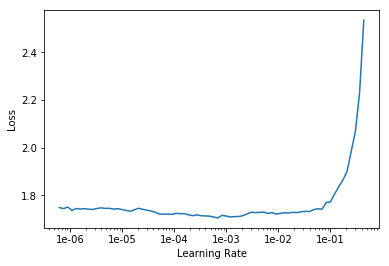

In [154]:
learner.recorder.plot()

Now there's a graph for you. No matter which learning rate we choose it doesn't look like any of them will be able to make progress on this problem. Let's double check that with a small learning rate like `1e-6`.

In [155]:
learner.fit_one_cycle(15, max_lr=slice(1e-6))

epoch,train_loss,valid_loss,error_rate
1,1.728823,1.659888,0.743333
2,1.723816,1.656305,0.743333
3,1.729168,1.651268,0.739167
4,1.729828,1.657930,0.740000
5,1.721756,1.663369,0.747500
6,1.724348,1.661269,0.741667
7,1.728686,1.649916,0.735000
8,1.718677,1.644944,0.731667
9,1.720143,1.641191,0.740000
10,1.725941,1.641156,0.727500


This makes more sense to me. There are no "features" in this image that would allow a network to look at it and instantly know how many circles are present. I suspect most humans can also not glance at one of these images and know whether or not there are 45 or 46 elements present. I suspect we would have to fall back to a different approach and manually count them out.

## One last experiment Part II

One last experiment I want to run is to answer the question of: Where does this "count-by-visual-features" approach begin to fail? For this we'll generate a larger dataset containing the number 1-20 and plot the confusion matrix.

/home/josh/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


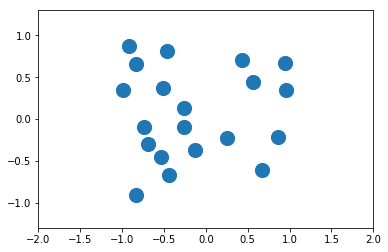

In [156]:
import os
from tqdm import tnrange

#Iterate over our 50 classes
for i in tnrange(1, 21):
    #Create 1,000 images of this class
    for j in tnrange(1000):
        
        directory = 'data/counting/' + str(i) + '/'
        path = directory + str(j) + '.png'
        os.makedirs(directory, exist_ok=True)

        #Get points
        x, y = createNonOverlappingPoints(i)
        #Create plot
        plt.cla()
        axes = plt.gca()
        axes.set_xlim([-2,2])
        axes.set_ylim([-2, 2])
        plt.scatter(x,y, s=200)
        plt.axes().set_aspect('equal', 'datalim')  # before `plt.show()`       
        #Save to disk
        plt.savefig(path)

In [158]:
path = 'data/counting'
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
learner = create_cnn(data, models.resnet34, metrics=error_rate)
learner.fit_one_cycle(15, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,error_rate
1,3.576485,3.272155,0.945000
2,3.568218,3.198439,0.938750
3,3.419560,3.062847,0.920750
4,3.315508,2.903335,0.899000
5,3.183623,2.759371,0.872250
6,3.096872,2.653086,0.848750
7,3.026155,2.570792,0.832250
8,2.963716,2.506326,0.817500
9,2.940848,2.460388,0.811250
10,2.906525,2.445886,0.815500


In [161]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)
print(interp)

In [165]:
interp.

torch.Size([4000, 20])

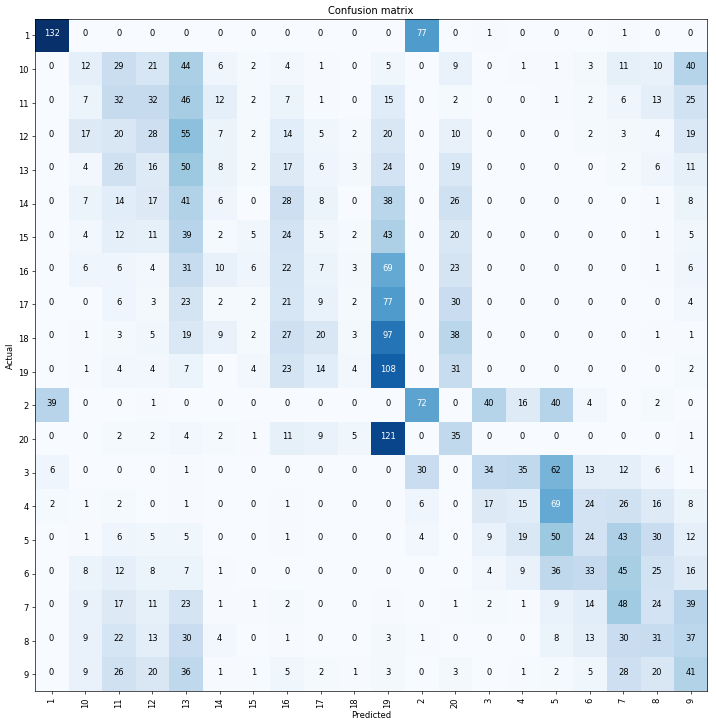

In [160]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

I can't figure out how to order the predicted/actual values in ascending order so it seems hard to get much out of this. For starters, it can predict class `1` very accurately and messes up in `19` and `20` pretty heavily.